# Capstone Project

##  Exploring neighborhoods in Toronto to find the neighborhood with the best Pizza Restaurant options

First we will start by extracting data related to neighborhoods in Toronto. This information is readily available on Wikipedia.

In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Foursquare Client Information

In [2]:
# client info
CLIENT_ID = 'TTEYGX0LFVPEVVOK01103USAWAFK35EH2AIBWYMKBTA0HTRU' # your Foursquare ID
CLIENT_SECRET = 'UNP2CXDYA0NIOCDQ0KJFCXLVJED0E00Z4YMRRGAJCPCCXCV3' # your Foursquare Secret
VERSION = '20200328' # Foursquare API version

In [3]:
#!python3 -m pip install lxml  ## Uncomment if missing library

Note: An older revision of the Wikipedia page is being used to extract this data due to the optimal formatting present on this page.

In [4]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=942655364"

We are using Pandas **read_html** method to extract the data

In [5]:
# Using pandas read_html to extract tables from url
url_tables = pd.read_html(url)

In [6]:
# Getting our required table and storing it in dataframe
codes_df = url_tables[0]
codes_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Some postal codes are associated with multiple neighborhood and therefore there is multiple entries for those postal codes. In the code below, we will use dataframe **group_by** function to group the data by Postal Codes and Borough names. Then we will aggregate the Neighbourhoods using the **agg** function on the group_by object.

In [7]:
codes_df = codes_df.groupby(['Postcode','Borough']).agg(lambda x: ', '.join(x.values))

Resetting index to make Postal Codes and Boroughs into columns

In [8]:
codes_df = codes_df.reset_index()

Getting rid of any **Not assigned** postal codes as those do not provide any useful information

In [9]:
codes_df = codes_df.where(codes_df['Borough']!="Not assigned").dropna()
codes_df.head()

,Postcode,Borough,Neighbourhood
1,M1B,Scarborough,"Rouge, Malvern"
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


Renaming the Column

In [10]:
codes_df.rename(columns={'Postcode':'PostalCode'},inplace=True)
codes_df.head()

,PostalCode,Borough,Neighbourhood
1,M1B,Scarborough,"Rouge, Malvern"
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [11]:
codes_df.shape

(103, 3)

Next we will get the latitude and longitude data from the CSV file online

In [12]:
import requests
url = 'http://cocl.us/Geospatial_data'
r = requests.get(url, allow_redirects=True)
open('geo.csv', 'wb').write(r.content)

2891

We will now read the CSV file into a dataframe 

In [13]:
geo_df = pd.read_csv('geo.csv')
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We will now use **pd.merge** to left join the toronto neighborhood dataframe with the geo dataframe on Postal Code field

In [14]:
toronto_df = pd.merge(codes_df, geo_df, how='left', on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Now we will write a function that finds nearby restaurants for a particular location (latitude/longitude). This function uses the Foursquare API and makes calls using the **venues/search** endpoint.

In [16]:
def getNearbyVenues(name, lat, lng, radius=3000, LIMIT=1000):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['venues']
    
    
    # return only relevant information for each nearby venue
    venue_list = []
    for v in results:
        try:
            postal_code = v['location']['postalCode'].split(r' ')[0][:3].upper()
            venue_list.append([
                name,
                v['id'],
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],
                postal_code,
                v['categories'][0]['name']])
        except:
            continue
        
   

    nearby_venues = pd.DataFrame([item for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'PostalCode',
                  'Venue Category']
    
        
    
    return(nearby_venues)

Loop through neighborhood and search nearby venues based on Latitude and Longitude

In [17]:
toronto_venues = pd.DataFrame(columns=['Neighborhood', 'PostalCode', 'Venue', 'Venue Category',
       'Venue Latitude', 'Venue Longitude'])
for (name,lat,lng) in zip(toronto_df['Neighbourhood'],toronto_df['Latitude'],toronto_df['Longitude']):
    toronto_venues = toronto_venues.append(getNearbyVenues(name,lat,lng),ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [18]:
toronto_venues['Venue Category'].value_counts()

Office                                      236
Residential Building (Apartment / Condo)    139
Coffee Shop                                 126
Bank                                         99
Salon / Barbershop                           87
Pizza Place                                  84
Automotive Shop                              79
Medical Center                               76
Dentist's Office                             74
Building                                     70
Pharmacy                                     64
Restaurant                                   62
Doctor's Office                              61
Church                                       57
Café                                         54
Sandwich Place                               52
Grocery Store                                51
Gas Station                                  51
Clothing Store                               50
Fast Food Restaurant                         44
Furniture / Home Store                  

Looking at the list of all the categories, an array of 'restaurant' type categories is created. This is later used to get all the restaurant type venues from the dataframe.

In [19]:
restaurant_keywords = ['Restaurant','Pizza','Café','Sandwich','Breakfast','Chicken','Burger','Deli','Food','BBQ','Diner','Wings','Burrito','Salad','Gourmet','Gastropub','Bistro','Bagel','Steak','Noodle','Taco','Shawarma','Buffet','Soup','Cafeteria']

Once a list is obtained for all the venues in Toronto's neighbourhoods, we will do a join **(pd.merge)** with toronto_df containing toronto neighborhood information. This also makes sure that the venues are assigned under the right postal code as there may have been some overlap created when the venues were obtained via Foursquare API call.

In [20]:
#toronto_venues.drop(columns=['Neighborhood'],inplace=True)
final_df = pd.merge(toronto_venues, toronto_df, how='inner', on='PostalCode')
final_df.shape

(4144, 11)

Now we will get all the venues that are of **Restaurants**

In [21]:
keyword = re.compile(r'|'.join(restaurant_keywords),re.IGNORECASE)
mask = final_df['Venue Category'].apply(lambda x: bool(keyword.search(str(x))))
restaurant_df = final_df[mask]
restaurant_df.shape

(810, 11)

Now we will use **group_by** to get a count of restaurants in each postal code and save that into a dataframe 

In [22]:
restaurant_count = restaurant_df.groupby(['PostalCode']).count().reset_index()
restaurant_count = restaurant_count.loc[:,['PostalCode','Venue']]
restaurant_count.rename(columns={'Venue':'Restaurant_Count'},inplace=True)
restaurant_count.head()

,PostalCode,Restaurant_Count
0,M1B,12
1,M1C,6
2,M1E,9
3,M1G,5
4,M1H,14


Now we will create a bar chart to display the top 8 neighborhoods in terms of the number of restaurants.

In [23]:
top8_df = restaurant_count.sort_values('Restaurant_Count', ascending=False).head(8)
top8_df = pd.merge(top8_df,codes_df,how='inner',on='PostalCode')
top8_df

,PostalCode,Restaurant_Count,Borough,Neighbourhood
0,M5H,34,Downtown Toronto,"Adelaide, King, Richmond"
1,M4L,23,East Toronto,"The Beaches West, India Bazaar"
2,M4K,20,East Toronto,"The Danforth West, Riverdale"
3,M4X,20,Downtown Toronto,"Cabbagetown, St. James Town"
4,M1R,18,Scarborough,"Maryvale, Wexford"
5,M5M,17,North York,"Bedford Park, Lawrence Manor East"
6,M2N,17,North York,Willowdale South
7,M6N,16,York,"The Junction North, Runnymede"


Text(0.5, 1.0, 'Top 8 Neighborhoods based on number of restaurants')

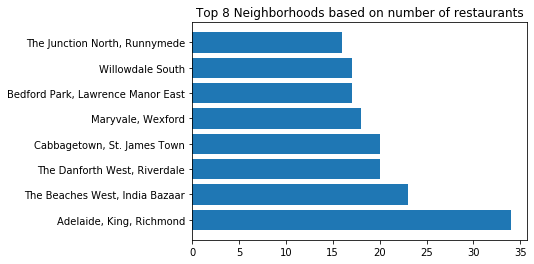

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.barh(top8_df['Neighbourhood'], top8_df['Restaurant_Count'])
plt.title('Top 8 Neighborhoods based on number of restaurants')

Now, in order to get all Pizza Restaurants, we get any venues where the name or the category contains 'Pizza' or similar keywords

In [26]:
pizza_keywords = ['Pizza','Pizzeria']

In [27]:
keyword = re.compile(r'|'.join(pizza_keywords),re.IGNORECASE)
mask = final_df['Venue Category'].apply(lambda x: bool(keyword.search(str(x))))
pizza_df = final_df[mask]
pizza_df.shape


(83, 11)

Now we will use **group_by** to get a count of restaurants in each postal code and save that into a dataframe 

In [28]:
pizza_count = pizza_df.groupby(['PostalCode']).count().reset_index()
pizza_count = pizza_count.loc[:,['PostalCode','Venue']]
pizza_count.rename(columns={'Venue':'Pizza_Count'},inplace=True)
pizza_count.head()

,PostalCode,Pizza_Count
0,M1B,1
1,M1C,1
2,M1G,2
3,M1H,1
4,M1J,2


Now we will create a bar chart to display the top 8 neighborhoods in terms of the number of restaurants.

In [29]:
top8pizza_df = pizza_count.sort_values('Pizza_Count', ascending=False).head(8)
top8pizza_df = pd.merge(top8pizza_df,codes_df,how='inner',on='PostalCode')
top8pizza_df

,PostalCode,Pizza_Count,Borough,Neighbourhood
0,M3N,3,North York,Downsview Northwest
1,M8V,3,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto"
2,M1M,3,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
3,M1N,3,Scarborough,"Birch Cliff, Cliffside West"
4,M4X,3,Downtown Toronto,"Cabbagetown, St. James Town"
5,M9N,3,York,Weston
6,M8W,2,Etobicoke,"Alderwood, Long Branch"
7,M4G,2,East York,Leaside


Text(0.5, 1.0, 'Top 8 Neighborhoods based on number of Pizza restaurants')

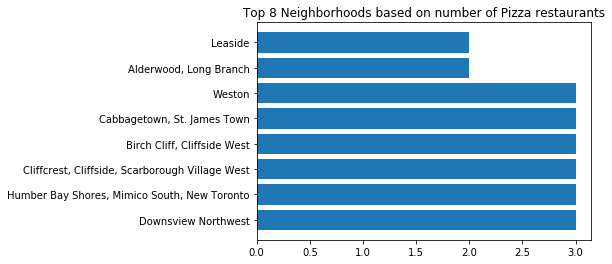

In [30]:
ax = plt.subplot(1,1,1)
ax.barh(top8pizza_df['Neighbourhood'], top8pizza_df['Pizza_Count'])
ax.set_title('Top 8 Neighborhoods based on number of Pizza restaurants')

Now for all these pizza restaurants, we will also fetch their overall rating from Foursquare using another endpoint (venue details)

Creating a function to get overall rating using Venue ID

In [33]:
def getLikesCount(venue_id):

    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        likes_count = result['response']['venue']['likes']['count']
    except:
        likes_count = 'NA'
    return likes_count

In [36]:
likes = []
for venue_id in pizza_df['ID']:
    likes_count = getLikesCount(venue_id)
    likes.append(likes_count)

new_pizza_df = pizza_df.copy()
new_pizza_df['Likes'] = likes


In [37]:
new_pizza_df.head()

,ID,Neighborhood,PostalCode,Venue,Venue Category,Venue Latitude,Venue Longitude,Borough,Neighbourhood,Latitude,Longitude,Likes
53,53b6ac2e498ea7ec7d43cd68,Upper Rouge,M1B,Yogi's Pizza & Wings,Pizza Place,43.817002,-79.211004,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0
66,5e7401a3948c0000083f2b08,"Highland Creek, Rouge Hill, Port Union",M1C,Mark’s Pizzas,Pizza Place,43.783293,-79.169771,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0
104,4b5a2f4ff964a520b7b228e3,"The Beaches West, India Bazaar",M4L,Pizzaiolo,Pizza Place,43.668953,-79.311683,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,4
141,4bcb794f3740b71390996265,Business Reply Mail Processing Centre 969 Eastern,M4L,Queen Margherita Pizza,Pizza Place,43.664685,-79.324164,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,86
192,4f88ecb2e4b0af04c0141561,Caledonia-Fairbanks,M6E,Hartley's Bistro,Pizza Place,43.695107,-79.455020,York,Caledonia-Fairbanks,43.689026,-79.453512,0


Now we will create a **histogram** to analyze the number of Likes

Text(0.5, 0, 'Number of Likes')

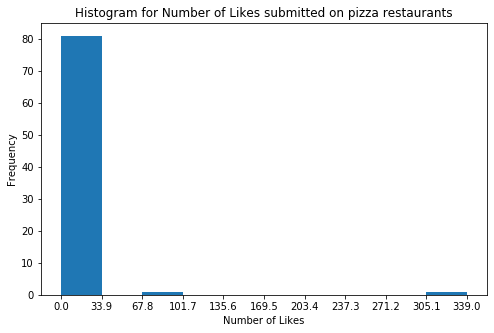

In [38]:
count, bin_edges = np.histogram(new_pizza_df['Likes'])
new_pizza_df['Likes'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
plt.title('Histogram for Number of Likes submitted on pizza restaurants')
plt.xlabel('Number of Likes')

Any value over 33 can be considered an outlier. If we include it in our dataset, it would significantly skew the result in the favor of that neighborhood. In order to present more balanced clustering of neighborhoods, we will cap the values at 33.

In [39]:
new_pizza_df.loc[new_pizza_df['Likes'] > 33,'Likes'] = 33

Now we will use **group_by** to get a mean number of Likes in each postal code and save that into a dataframe 

In [40]:
pizza_like_count = new_pizza_df.groupby(['PostalCode']).mean()['Likes'].reset_index()

Now we will use a bar chart to show the top 8 neighborhoods based on the mean number of likes

In [41]:
likes_df = pizza_like_count.sort_values('Likes',ascending=False).head(8)
likes_df = pd.merge(likes_df, codes_df, how='inner', on='PostalCode')
likes_df

,PostalCode,Likes,Borough,Neighbourhood
0,M6J,31.0,West Toronto,"Little Portugal, Trinity"
1,M4S,26.0,Central Toronto,Davisville
2,M4L,18.5,East Toronto,"The Beaches West, India Bazaar"
3,M8W,9.5,Etobicoke,"Alderwood, Long Branch"
4,M5J,9.0,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station"
5,M2R,6.0,North York,Willowdale West
6,M2N,5.0,North York,Willowdale South
7,M6H,4.0,West Toronto,"Dovercourt Village, Dufferin"


Text(0.5, 0, 'Mean number of likes')

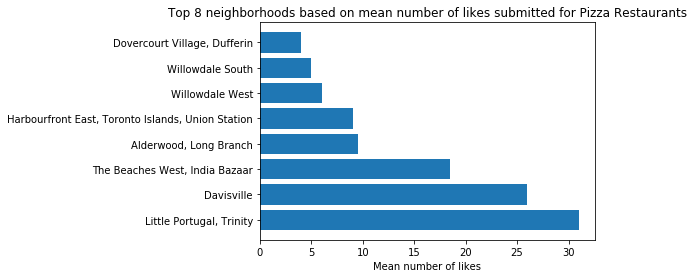

In [42]:
pizza_like_count.sort_values('Likes',ascending=False).head(8) 
ax = plt.subplot(1,1,1)
ax.barh(likes_df['Neighbourhood'],likes_df['Likes'])
plt.title('Top 8 neighborhoods based on mean number of likes submitted for Pizza Restaurants')
plt.xlabel('Mean number of likes')


Now building our feature set consisting of number of Restaurants, number of Pizza Restaurants and mean number of Likes for each postal code.

In [43]:
pizza_like_count = new_pizza_df.groupby(['PostalCode']).mean()['Likes'].reset_index()

In [44]:
features_df = pd.merge(codes_df, restaurant_count, how='left', on='PostalCode')
features_df = pd.merge(features_df, pizza_count, how='left', on='PostalCode')
features_df = pd.merge(features_df, pizza_like_count, how='left', on='PostalCode')
features_df.head()

,PostalCode,Borough,Neighbourhood,Restaurant_Count,Pizza_Count,Likes
0,M1B,Scarborough,"Rouge, Malvern",12.0,1.0,0.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",6.0,1.0,0.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",9.0,NaN,NaN
3,M1G,Scarborough,Woburn,5.0,2.0,1.0
4,M1H,Scarborough,Cedarbrae,14.0,1.0,1.0


Now we will take a look at the missing values and resolve them.

In [45]:
features_df = features_df.fillna(0).sort_index()

Now we will apply KMeans clustering algorithm on the feature set

First extract feature set and normalize it

In [46]:
features = features_df.loc[:,['Restaurant_Count','Pizza_Count','Likes']].values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(features)

Now apply KMeans Algorithm and divide the features into clusters. We will use the **Elbow method** to get the optimal number of clusters.

In [47]:
# import k-means 
from sklearn.cluster import KMeans
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)



Text(0.5, 1.0, 'Sum of squared error vs number of clusters')

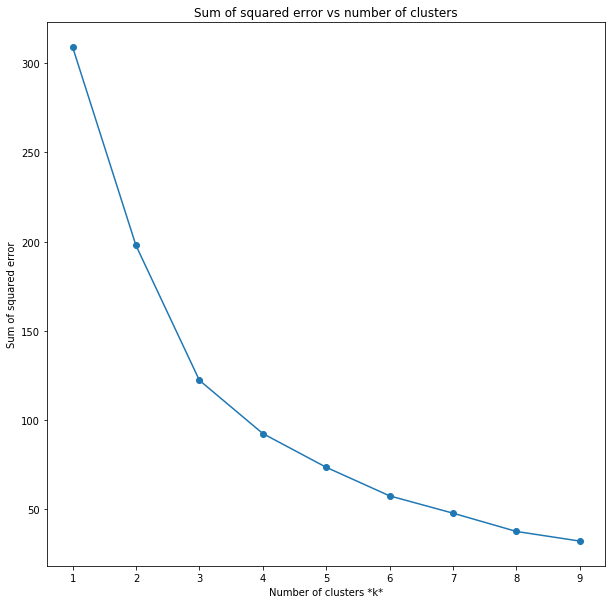

In [48]:
# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared error')
plt.title('Sum of squared error vs number of clusters')

For the above plot, it can be seen that the sum of squared error (distance) decreases rapidly until k=3 and then it flattens out. We will select k=4 for the number of clusters.

In [50]:
k_clusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels.shape

(103,)

In [51]:
features_df['Labels'] = labels
features_df.head(10)

,PostalCode,Borough,Neighbourhood,Restaurant_Count,Pizza_Count,Likes,Labels
0,M1B,Scarborough,"Rouge, Malvern",12.0,1.0,0.000000,0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",6.0,1.0,0.000000,1
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",9.0,0.0,0.000000,0
3,M1G,Scarborough,Woburn,5.0,2.0,1.000000,2
4,M1H,Scarborough,Cedarbrae,14.0,1.0,1.000000,0
5,M1J,Scarborough,Scarborough Village,6.0,2.0,0.000000,2
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",5.0,2.0,0.000000,2
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",9.0,1.0,3.000000,0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",6.0,3.0,1.666667,2
9,M1N,Scarborough,"Birch Cliff, Cliffside West",14.0,3.0,0.666667,2


The best neighborhood for Pizza restaurants based on the features (extracted from FourSquare) is **Little Portugal**, Trinity in West Toronto

In [52]:
clusters_df = features_df.groupby('Labels').mean()

Text(0.5, 1.0, 'Difference between Clusters')

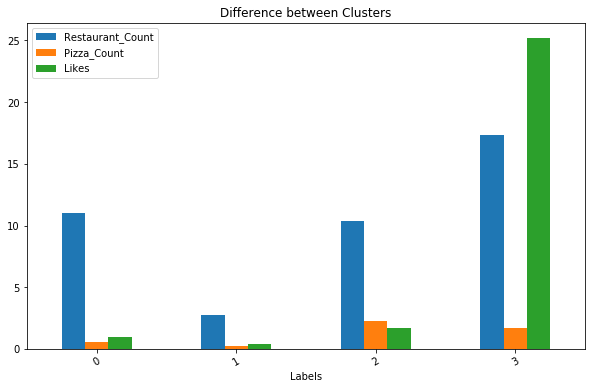

In [53]:
clusters_df.plot(kind='bar', figsize=(10,6))
plt.xticks(rotation=30)
plt.title('Difference between Clusters')

In [54]:
features_df.loc[features_df['Labels']==3]

,PostalCode,Borough,Neighbourhood,Restaurant_Count,Pizza_Count,Likes,Labels
42,M4L,East Toronto,"The Beaches West, India Bazaar",23.0,2.0,18.5,3
47,M4S,Central Toronto,Davisville,13.0,1.0,26.0,3
77,M6J,West Toronto,"Little Portugal, Trinity",16.0,2.0,31.0,3


Now we will visualize the clusters on a map of Toronto.

In [61]:
# create map
import folium
latitude, longitude = 43.65,-79.38
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


In [56]:
map_df = pd.merge(features_df, geo_df, how='left', on='PostalCode')

In [57]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(k_clusters)
ys = [i + x + (i*x)**3 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)


['#8000ff', '#2adddd', '#d4dd80', '#ff0000']


In [58]:
# add markers to the map

for lat, lon, poi, cluster in zip(map_df['Latitude'], map_df['Longitude'], map_df['Neighbourhood'], map_df['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-fymr{font-weight:bold;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-fymr">Color</th>
    <th class="tg-1wig">Cluster</th>
  </tr>
   <tr>
    <td class="tg-0lax" bgcolor='#ff0000'></td>
    <td class="tg-0lax">0</td>
  </tr>
  <tr>
    <td class="tg-0lax" bgcolor='#8000ff'></td>
    <td class="tg-0lax">1</td>
  </tr>
    <tr>
    <td class="tg-0lax" bgcolor='2adddd'></td>
    <td class="tg-0lax">2</td>
  </tr>
  <tr>
    <td class="tg-0lax" bgcolor='#d4dd80'></td>
    <td class="tg-0lax">3</td>
  </tr>

</table>

In [59]:
cluster3_df= map_df.loc[features_df['Labels']==3]
cluster3_df


,PostalCode,Borough,Neighbourhood,Restaurant_Count,Pizza_Count,Likes,Labels,Latitude,Longitude
42,M4L,East Toronto,"The Beaches West, India Bazaar",23.0,2.0,18.5,3,43.668999,-79.315572
47,M4S,Central Toronto,Davisville,13.0,1.0,26.0,3,43.704324,-79.388790
77,M6J,West Toronto,"Little Portugal, Trinity",16.0,2.0,31.0,3,43.647927,-79.419750


In [60]:
latitude, longitude = 43.65,-79.38
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lon, poi, cluster in zip(cluster3_df['Latitude'], cluster3_df['Longitude'], cluster3_df['Neighbourhood'], cluster3_df['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='#ff0000',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.7).add_to(map_clusters)
    #folium.Marker([lat, lng], popup=label).add_to(map_clusters)
     
map_clusters